In [ ]:
import os
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Masking, Bidirectional, LSTM, TimeDistributed, Dense, Activation, BatchNormalization
from tensorflow.keras.regularizers import L2

import warnings
warnings.filterwarnings('ignore')

In [28]:
EXPERIMENT_DIR = "experiments/03_BDLSTM_NadamReg/"

BATCH_SIZE = 512
PIECE_LEN = 1024
n_feature = 43
n_hidden = 100
n_pitch = 53
learning_rate = 0.001

## build dataset

In [ ]:
def load_npy_data(x_path, y_path, offset):
    x = np.load(x_path)
    y = np.load(y_path)
    if x.shape[0] >= offset+PIECE_LEN:
        return x[offset:offset+PIECE_LEN].astype(np.float64), y[offset:offset+PIECE_LEN].astype(np.float64)
    else:
        pad_count = offset + PIECE_LEN - x.shape[0]
        x = np.pad(x[offset:], ((0, pad_count), (0, 0)), 'constant', constant_values=-1).astype(np.float64)
        y = np.pad(y[offset:], ((0, pad_count), (0, 0)), 'constant', constant_values=-1).astype(np.float64)
        return x, y

def generate_dataset(input_dir: str):
    x_paths = []
    y_paths = []
    offsets = []
    for file_name in sorted(os.listdir(input_dir)):
        if file_name.endswith(".ans.npy"):
            y_path = str(os.path.join(input_dir, file_name))
            x_path = str(os.path.join(input_dir, file_name.replace(".ans.npy", ".npy")))
            assert os.path.exists(x_path), f"corresponding input file {x_path} doesn't exist"
            y_content = np.load(y_path)
            for offset in range(0, y_content.shape[0], PIECE_LEN):
                y_paths.append(y_path)
                x_paths.append(x_path)
                offsets.append(offset)

    
    train_dataset = tf.data.Dataset.from_tensor_slices((x_paths, y_paths, offsets)).shuffle(100000)
    train_dataset = train_dataset.map(lambda x_path, y_path, offset: tf.numpy_function(load_npy_data, [x_path, y_path, offset], [tf.float64, tf.float64]))
    train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(-1).cache()
    
    return train_dataset

In [ ]:
# train_dataset = generate_dataset("./preprocessed_dataset/irealpro_dataset_v2_simple/")
train_dataset = generate_dataset("preprocessed_dataset/augmentation_v2_simple")
validation_dataset = generate_dataset("preprocessed_dataset/midkar_v2_simple")

## build model

In [29]:
# print("Creating model")
input = tf.keras.Input(shape=(PIECE_LEN, n_feature))  
x = Masking(mask_value=-1, input_shape=(PIECE_LEN, n_feature), name="mask")(input) # Ignore Padded Data
x = Bidirectional(LSTM(units=n_hidden, input_shape=(1, n_feature), return_sequences=True, kernel_regularizer=L2(0.001)))(x)
x = TimeDistributed(Dense(n_pitch, activation="softmax", kernel_regularizer=L2(0.01)), name="output")(x)
model = tf.keras.Model(inputs=input, outputs=x)
print(model.summary())

optimizer=tf.keras.optimizers.experimental.Nadam(learning_rate=learning_rate)
# optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1024, 43)]        0         
                                                                 
 mask (Masking)              (None, 1024, 43)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 1024, 200)        115200    
 nal)                                                            
                                                                 
 output (TimeDistributed)    (None, 1024, 53)          10653     
                                                                 
Total params: 125,853
Trainable params: 125,853
Non-trainable params: 0
_________________________________________________________________
None


## loss/accuracy function

In [30]:
@tf.function
def masked_loss_function(y_true, y_pred):
    mask = tf.math.not_equal(tf.reduce_sum(y_true, axis=2), -1*n_pitch)
    loss = tf.losses.categorical_crossentropy(y_true, y_pred)
    mask = tf.cast(mask, loss.dtype)
    loss *= mask
    return tf.reduce_mean(loss)

@tf.function
def masked_accuracy(y_true, y_pred):
    mask = tf.math.not_equal(tf.reduce_sum(y_true, axis=2), -1*n_pitch)
    acc = tf.metrics.categorical_accuracy(y_true, y_pred)
    mask = tf.cast(mask, acc.dtype)
    acc *= mask
    return tf.reduce_mean(acc)

### restore checkpoint

In [31]:
checkpoint_dir = './checkpoints/03_BDLSTM_NadamReg'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 model=model)

In [ ]:
# checkpoint.restore(checkpoint_prefix+"-1")

## training

In [32]:
@tf.function
def train_step(x, y):
    loss = 0
    with tf.GradientTape() as tape:
        pred = model(x)
        
        loss = masked_loss_function(y, pred)
        weight_decay = tf.reduce_sum(model.losses)
        loss += weight_decay

    gradients = tape.gradient(loss, model.trainable_variables)
    gradients = [(tf.clip_by_value(grad, clip_value_min=-1.0, clip_value_max=1.0)) for grad in gradients]

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    acc = masked_accuracy(y, pred)

    return loss, acc

In [34]:
@tf.function
def val_step(x, y):
    pred = model(x)
    loss = masked_loss_function(y, pred)
    weight_decay = tf.reduce_sum(model.losses)
    loss += weight_decay
    acc = masked_accuracy(y, pred)
    return loss, acc

In [35]:
loss_history = []
val_loss_history = []
acc_history = []
val_acc_history = []
# loss_history = np.load("experiments/BDLSTM_simple/history.npy").tolist()

In [36]:
# set the epochs for training
EPOCHS = 300

for epoch in range(EPOCHS):
    start = time.time()

    # get the initial hidden state of gru
    total_loss = 0
    total_acc = 0
    steps_per_epoch = 0
    val_total_loss = 0
    val_total_acc = 0
    val_steps_per_epoch = 0

    for x, y in train_dataset:
        batch_loss, batch_acc = train_step(x, y)
        total_loss += batch_loss
        total_acc += batch_acc
        steps_per_epoch += 1
    
    for x, y in validation_dataset:
        val_batch_loss, val_batch_acc = val_step(x, y)
        val_total_loss += val_batch_loss
        val_total_acc += val_batch_acc
        val_steps_per_epoch += 1
    
    print(f'Epoch {epoch+1} Loss {total_loss / steps_per_epoch:.4f} Acc {total_acc / steps_per_epoch:.4f}')
    print(f'Validation Loss {val_total_loss / val_steps_per_epoch:.4f} Acc {val_total_acc / val_steps_per_epoch:.4f}')
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    loss_history.append(float(total_loss / steps_per_epoch))
    acc_history.append(float(total_acc / steps_per_epoch))
    val_loss_history.append(float(val_total_loss / val_steps_per_epoch))
    val_acc_history.append(float(val_total_acc / val_steps_per_epoch))

    if (epoch+1) % 100 == 0:
        checkpoint.save(checkpoint_prefix)

Epoch 1 Loss 3.4040 Acc 0.1506
Validation Loss 2.9183 Acc 0.1743
Time taken for 1 epoch 21.578959703445435 sec

Epoch 2 Loss 2.6754 Acc 0.2020
Validation Loss 2.5552 Acc 0.1864
Time taken for 1 epoch 12.805639266967773 sec

Epoch 3 Loss 2.4096 Acc 0.2101
Validation Loss 2.3696 Acc 0.1954
Time taken for 1 epoch 12.791704416275024 sec

Epoch 4 Loss 2.2682 Acc 0.2154
Validation Loss 2.2654 Acc 0.2001
Time taken for 1 epoch 12.82932996749878 sec

Epoch 5 Loss 2.1871 Acc 0.2189
Validation Loss 2.2040 Acc 0.2044
Time taken for 1 epoch 12.80416464805603 sec

Epoch 6 Loss 2.1378 Acc 0.2210
Validation Loss 2.1640 Acc 0.2075
Time taken for 1 epoch 12.83621335029602 sec

Epoch 7 Loss 2.1058 Acc 0.2228
Validation Loss 2.1358 Acc 0.2097
Time taken for 1 epoch 12.857598543167114 sec

Epoch 8 Loss 2.0811 Acc 0.2246
Validation Loss 2.1142 Acc 0.2130
Time taken for 1 epoch 12.85135293006897 sec

Epoch 9 Loss 2.0627 Acc 0.2264
Validation Loss 2.0974 Acc 0.2156
Time taken for 1 epoch 12.896713733673096 s

KeyboardInterrupt: 

In [39]:
total_loss = 0
total_acc = 0
steps_per_epoch = 0
val_total_loss = 0
val_total_acc = 0
val_steps_per_epoch = 0

for x, y in train_dataset:
    batch_loss, batch_acc = val_step(x, y)
    total_loss += batch_loss
    total_acc += batch_acc
    steps_per_epoch += 1
    
for x, y in validation_dataset:
    val_batch_loss, val_batch_acc = val_step(x, y)
    val_total_loss += val_batch_loss
    val_total_acc += val_batch_acc
    val_steps_per_epoch += 1

print(f'Training Loss {total_loss / steps_per_epoch:.4f} Acc {total_acc / steps_per_epoch:.4f}')
print(f'Validation Loss {val_total_loss / val_steps_per_epoch:.4f} Acc {val_total_acc / val_steps_per_epoch:.4f}')

Training Loss 1.8680 Acc 0.2733
Validation Loss 1.9465 Acc 0.2471


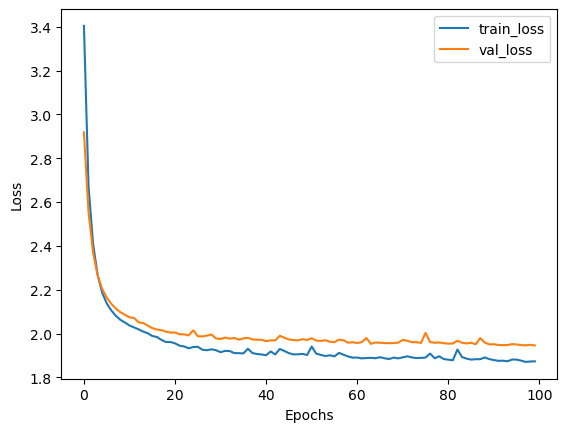

In [40]:
plt.plot(loss_history, label="train_loss")
plt.plot(val_loss_history, label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

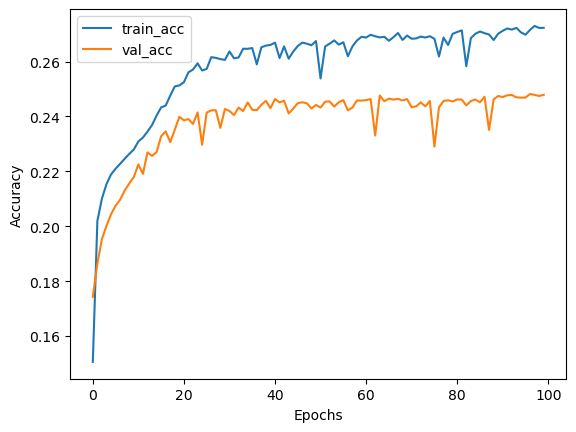

In [41]:
plt.plot(acc_history, label="train_acc")
plt.plot(val_acc_history, label="val_acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [42]:
checkpoint.save(checkpoint_prefix)
np.save(EXPERIMENT_DIR+"/loss_history.npy", np.array(loss_history))
np.save(EXPERIMENT_DIR+"/acc_history.npy", np.array(acc_history))
np.save(EXPERIMENT_DIR+"/val_loss_history.npy", np.array(val_loss_history))
np.save(EXPERIMENT_DIR+"/val_acc_history.npy", np.array(val_acc_history))

In [ ]:
# loss_history = np.load(EXPERIMENT_DIR+"/loss_history.npy")
# acc_history = np.load(EXPERIMENT_DIR+"/acc_history.npy")
# val_loss_history = np.load(EXPERIMENT_DIR+"/val_loss_history.npy")
# val_acc_history = np.load(EXPERIMENT_DIR+"/val_acc_history.npy")

## predict

In [43]:
def slice_per_step(a):
    # add -1 to the end of each sample to make them the same length per step(piece_length)
    original_length = a.shape[0]
    pad_count = PIECE_LEN - (original_length % PIECE_LEN)
    print(a.shape, end=' ')
    if pad_count!=PIECE_LEN : 
        print('pad by',pad_count, end=' ')
        a = np.pad(a, ((0, pad_count), (0, 0)), 'constant', constant_values=-1)
    # reshape into per step
    a = np.reshape(a, (-1, PIECE_LEN, a.shape[1]))
    print('to',a.shape)
    return a, original_length

In [44]:
import midi_np_translation.output2midi_v2_simple as output2midi

In [45]:
def test_and_translate_to_midi(input_path, ref_midi_path, output_path):
    test_file = np.load(input_path)
    padded_input, original_length = slice_per_step(test_file)
    test_result = np.reshape(model.predict(padded_input), (-1, 53))[:original_length]
    print(test_result.shape)
    output2midi.output_to_midi(test_result, ref_midi_path, output_path)

In [46]:
test_and_translate_to_midi(input_path="preprocessed_dataset/irealpro_dataset_v2_simple/Autumn Leaves_o0.mid.npy",
                           ref_midi_path="input_midi/irealpro_transposed/Autumn Leaves_o0.mid",
                           output_path=EXPERIMENT_DIR+"autumn_irealpro.mid")
test_and_translate_to_midi(input_path="preprocessed_dataset/dense_v2_simple/AutumnLeaves_o0.mid.npy",
                           ref_midi_path="input_midi/transpose_augmentation/AutumnLeaves_o0.mid",
                           output_path=EXPERIMENT_DIR+"autumn_arr.mid")
test_and_translate_to_midi(input_path="preprocessed_dataset/midkar_v2_simple/autumn_leaves_pt_dm.mid.npy",
                           ref_midi_path="input_midi/midkar/autumn_leaves_pt_dm.mid",
                           output_path=EXPERIMENT_DIR+"autumn_val.mid")
test_and_translate_to_midi(input_path="preprocessed_dataset/midkar_v2_simple/the_song_is_you_mw.mid.npy",
                           ref_midi_path="input_midi/midkar/the_song_is_you_mw.mid",
                           output_path=EXPERIMENT_DIR+"the_song_is_you.mid")
test_and_translate_to_midi(input_path="preprocessed_dataset/midkar_v2_simple/a_night_in_tunisia_2_jc.mid.npy",
                           ref_midi_path="input_midi/midkar/a_night_in_tunisia_2_jc.mid",
                           output_path=EXPERIMENT_DIR+"tunisia.mid")

(1560, 43) pad by 488 to (2, 1024, 43)
1/1 [==============================] - 2s 2s/step
(1560, 53)
(1712, 43) pad by 336 to (2, 1024, 43)
1/1 [==============================] - 0s 31ms/step
(1712, 53)
(3731, 43) pad by 365 to (4, 1024, 43)
1/1 [==============================] - 0s 31ms/step
(3731, 53)
(3137, 43) pad by 959 to (4, 1024, 43)
1/1 [==============================] - 0s 31ms/step
(3137, 53)
(1536, 43) pad by 512 to (2, 1024, 43)
1/1 [==============================] - 0s 33ms/step
(1536, 53)
